In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [248]:
TEXT_COLOR = '#313131'
LINE_COLORS = ['#00A082', '#F2CC38', '#9B59B6', '#3498DB', '#F39C12']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif', # 'Open Sans',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [3]:
def scree_plot(pca):
    pc_comps = np.arange(pca.n_components_) + 1
    
    fig, ax = plt.subplots(figsize=(8, 5))
    _ = sns.barplot(x=pc_comps, y=pca.explained_variance_ratio_, color=LINE_COLORS[2])
    _ = sns.lineplot(x=pc_comps-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

    plt.title('Scree Plot')
    plt.xlabel('N-th Principal Component')
    plt.ylabel('Variance Explained')
    plt.ylim(0, 1)
    plt.show()

# Load data

In [421]:
data = pd.read_csv('../data/house-prices-dataset/train.csv')

In [422]:
data = data.drop('Id', axis=1)

In [423]:
# Selecting top-predictor columns IMO
cols = [
    'OverallQual', 
    'GrLivArea',
    'ExterQual',
    'GarageCars',
    'YearBuilt',
    'YearRemodAdd',
    'TotRmsAbvGrd',
    'Foundation',
    'Fireplaces',
    'FireplaceQu',
    'HeatingQC',
    'SalePrice'
]

In [424]:
data = data[cols]

### Encode categorical features

In [425]:
def col_to_dummies(df, col):
    return pd.concat(
        [data, pd.get_dummies(data[col], prefix=col, drop_first=True)], 
        axis=1
    ).drop(col, axis=1)

In [426]:
data['FireplaceQu'] = data['FireplaceQu'].map({
    np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
})

In [427]:
data['HeatingQC'] = data['HeatingQC'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [428]:
data['ExterQual'] = data['ExterQual'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [429]:
data = col_to_dummies(data, 'Foundation')

# PCA on all selected features

# Standardize

In [436]:
df = data.copy()

In [437]:
y_col = 'SalePrice'
x_cols = df.columns.drop(y_col)

In [438]:
scaler = StandardScaler()

In [439]:
df[x_cols] = scaler.fit_transform(df[x_cols])

In [364]:
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [440]:
df_pca = df.copy()

In [441]:
pca = PCA()
df_pca[x_cols] = pca.fit_transform(df_pca[x_cols])

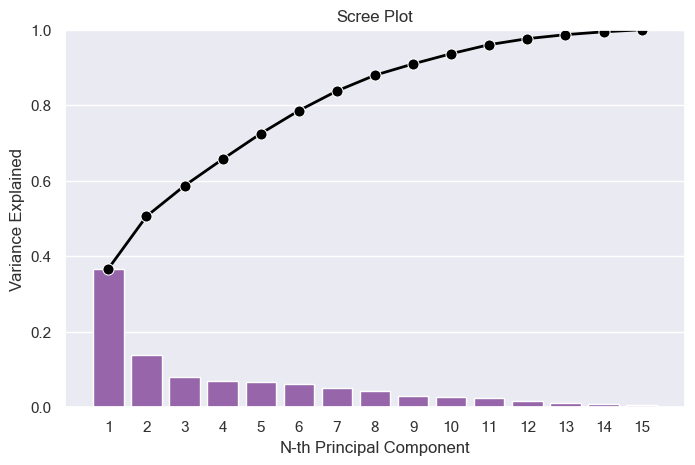

In [442]:
scree_plot(pca)

In [443]:
df_pca = df_pca[x_cols.tolist() + [y_col]]

In [444]:
df_pca.columns = [f"pc{i}" for i in range(1, len(x_cols)+1)] + [y_col]

Text(0.5, 1.0, 'First two principal components - Projected by PCA')

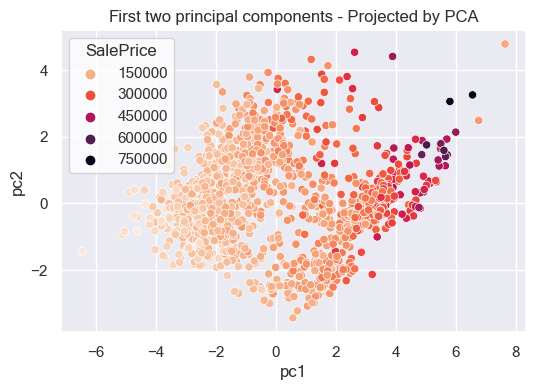

In [445]:
sns.scatterplot(data=df_pca, x='pc1', y='pc2', hue=y_col, palette='rocket_r')
plt.title("First two principal components - Projected by PCA")

# Reduce smaller number of features

### 3 -> 2 features

We will bucketize `SalePrice` into 3 ranked bins with the same amount of data in each. Then we will remove one of the 3 dimensions and see how 3D data compares to 2D.

In [392]:
df = data.copy()

In [393]:
df.loc[
    df['SalePrice'] < df['SalePrice'].quantile(0.333),
    'y'
] = 0

In [394]:
df.loc[
    (df['SalePrice'] > df['SalePrice'].quantile(0.333)) & (df['SalePrice'] < df['SalePrice'].quantile(0.666)),
    'y'
] = 1

In [395]:
df.loc[
    df['SalePrice'] > df['SalePrice'].quantile(0.666),
    'y'
] = 2

<AxesSubplot:xlabel='y', ylabel='count'>

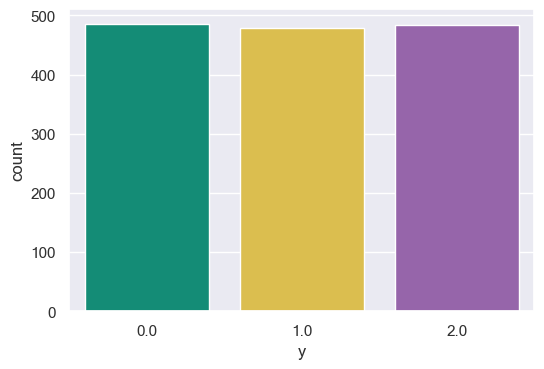

In [396]:
sns.countplot(data=df, x='y')

In [397]:
import plotly.express as px

In [398]:
df = df.dropna()

In [399]:
x_cols = ['OverallQual', 'GrLivArea', 'YearBuilt']

In [400]:
df = df[x_cols + ['y']]

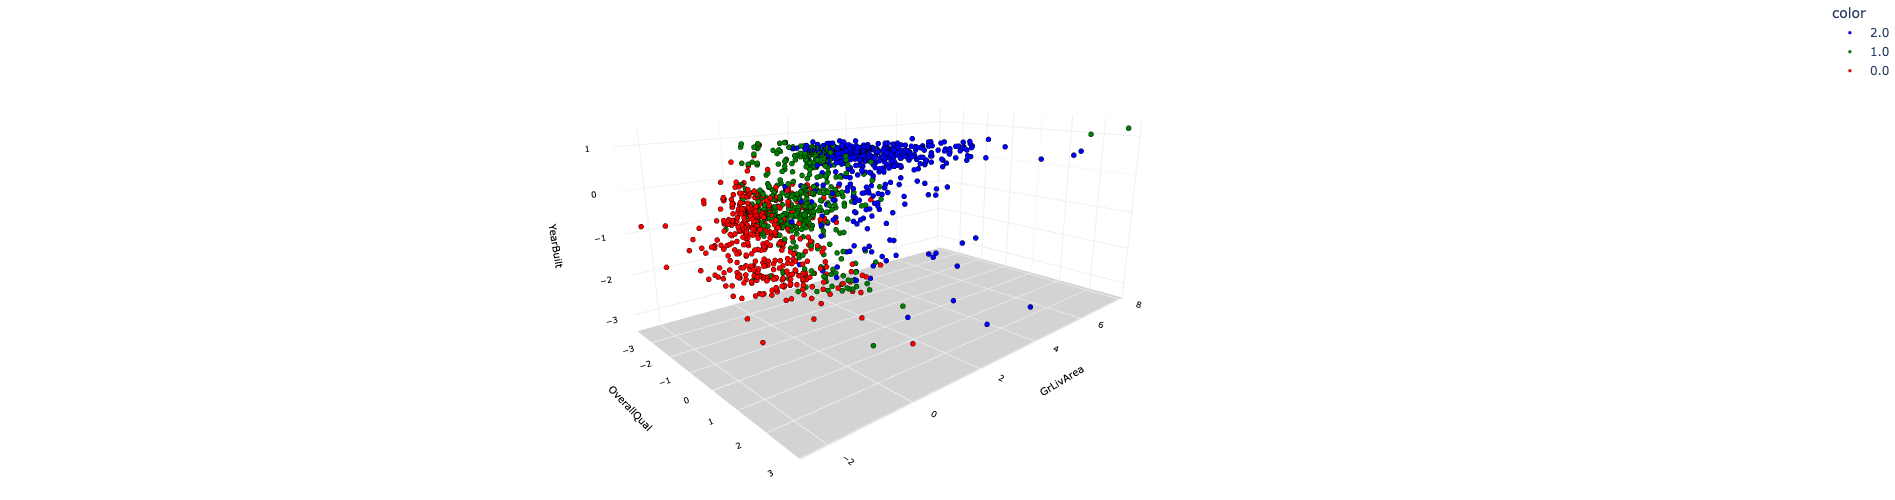

In [401]:
# Before PCA
colors = ['blue', 'green', 'red']
fig = px.scatter_3d(df, x='OverallQual', y='GrLivArea', z='YearBuilt', color=df['y'].astype(str), color_discrete_sequence=colors, height=500, width=1000)
fig.update_layout(showlegend=True,
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                    center=dict(x=0, y=0, z=-0.1),
                                    eye=dict(x=1.5, y=-1.4, z=0.5)),
                  margin=dict(l=0, r=0, b=0, t=0),
                  scene=dict(xaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             yaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             zaxis=dict(backgroundcolor='lightgrey',
                                        color='black', 
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10))))
fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
fig.show()

In [402]:
pca = PCA()

In [403]:
df_pca = df.copy()

In [404]:
df_pca[x_cols] = pca.fit_transform(df[x_cols])

In [405]:
df_pca.columns = [f"pc{i}" for i in range(1, len(x_cols)+1)] + ['y']

Text(0.5, 1.0, 'Composition of each principal component')

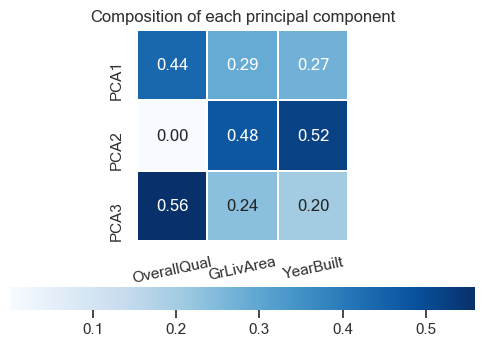

In [407]:
# Feature Weight
_ = sns.heatmap(
    pca.components_**2,
    yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
    xticklabels=list(x_cols),
    annot=True,
    fmt='.2f',
    square=True,
    linewidths=0.05,
    cmap='Blues',
    cbar_kws={"orientation": "horizontal"}
)
plt.xticks(rotation=12)
plt.title("Composition of each principal component")

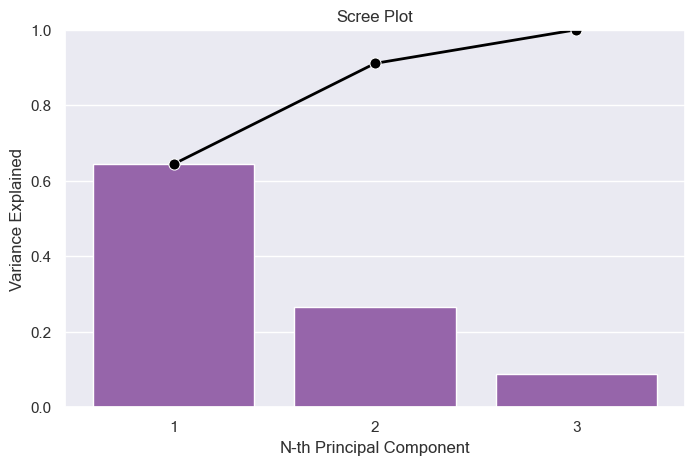

In [408]:
scree_plot(pca)

Text(0.5, 1.0, 'First two principal components - Projected by PCA')

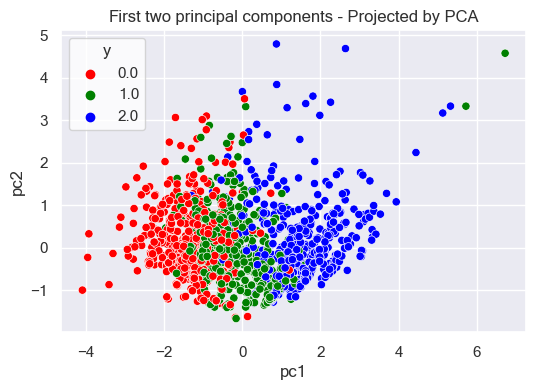

In [409]:
sns.scatterplot(data=df_pca, x='pc1', y='pc2', hue='y', palette=['red', 'green', 'blue'])
plt.title("First two principal components - Projected by PCA")

Text(0.5, 1.0, 'First two features - Without PCA')

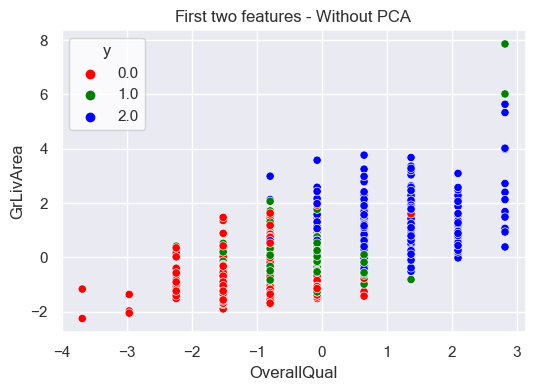

In [410]:
sns.scatterplot(data=df, x='OverallQual', y='GrLivArea', hue='y', palette=['red', 'green', 'blue'])
plt.title("First two features - Without PCA")

---

# Use PC as a feature for ML

In [414]:
from sklearn.model_selection import train_test_split

In [454]:
from sklearn.linear_model import LinearRegression

In [458]:
from sklearn.metrics import mean_squared_error

In [460]:
df = data.copy()

In [463]:
X = df.drop(y_col, axis=1)
y = df[y_col]

15

In [484]:
results = {
    "n_comps": [],
    "rmse": [],
}

for n in range(1, X.shape[1]+1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Transform the target
    y_train = y_train.values
    y_train_log = np.log(y_train)
    y_test = y_test.values

    # Apply PCA
    pca = PCA(n_components=n)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # Train a model
    model = LinearRegression()
    model.fit(X_train, y_train_log)
    
    # Re-transform the targets
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results["n_comps"].append(n)
    results["rmse"].append(rmse)

In [485]:
res = pd.DataFrame(results)

Text(0.5, 1.0, 'Error vs. How many principal components were used')

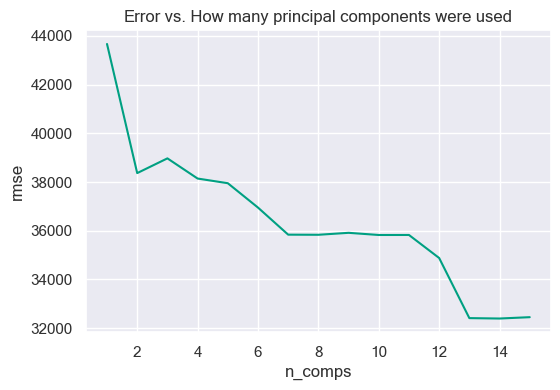

In [486]:
sns.lineplot(data=res, x='n_comps', y='rmse')
plt.title("Error vs. How many principal components were used")

---